# Winter 2022 & 2023 Wind Events as Measured by SAIL

Author: Daniel Hogan
Created: January 17, 2024

This notebook will look at wind speed, direction, and sublimation for the entire period and build an hourly averaged dataset.
I'll try to answer these three questions:
1) What events had the highest percentile of wind speeds?
2) What were the general storm characteristics? Were they related?
3) How much sublimation over the season came from these events?

### Imports


In [1]:
# general
import os
import glob
import datetime as dt
import json
# data 
import xarray as xr 
from sublimpy import utils, variables, tidy, turbulence
import numpy as np
import pandas as pd
from act import discovery, plotting
# plotting
import matplotlib.pyplot as plt
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# helper tools
from scripts.get_sail_data import get_sail_data
from scripts.helper_funcs import create_windrose_df, simple_sounding, mean_sounding
import scripts.helper_funcs as hf
from metpy import calc, units
# make plotly work 
init_notebook_mode(connected=True)
cf.go_offline()

nctoolkit is using Climate Data Operators version 2.3.0


## 1. What events had the highest percentile of wind speeds?
We will begin to address this by looking at daily average wind speeds during the SAIL campaign. I'll define winter in this case as spanning the same periods as the SOS campaign for the 2023 winter (November 29 - May 7) and the period when at least 6" of snow were on the ground per billy barr's measurement. This is going to include a storm that brought his site up from 1" to 6" because I want to include that storm and see how it influenced the season (not much I imagine). So the 2022 winter spans December 6 to May 1. The end is loosly defined as when snow melt rates really start to pick up. In 2022, between April 23-May 1 we lost 41 cm of snow. A similar thing happed in 2023 between April 29 and May 7. Could be more direct with this definition, but we'll start with that. Thus, with a shorter winter, we expect less sublimation to occur in the 2022 winter.
To 
classify the top 90th percentile of windy days during the main snow season for 2022 and 2023. This may need to be broken down further to capture wind events, but we'll start with this. We'll begin by comparing the days for 3-20 m wind speeds and compare tower-to-tower to make sure we have consistency at our location.

1) We'll first make some box plots of daily average wind speeds at Gothic from SAIL, billy data, and 10m UW tower wind speed.
2) We'll make a timeseries plot for each height bin and mark out the highest percentile of wind speeds for the year
3) We'll then filter to the days with the highest 5% of wind speeds over each winter and see how they compare to each other.


### Setup to download SAIL data

In [2]:
# Function to load ARM credentials
def load_arm_credentials(credential_path):
    with open(credential_path, 'r') as f:
        credentials = json.load(f)
    return credentials
# Location of ARM credentials
credential_path = '/home/dlhogan/.act_config.json'
credentials = load_arm_credentials(credential_path)
# api token and username for ARM
api_username = credentials.get('username')
api_token = credentials.get('token')

sail_datastream_dict = {
    "radiosonde":"gucsondewnpnM1.b1",
    "met":"gucmetM1.b1",
    "eddy_covariance_kettle_ponds":"guc30qcecorS3.s1",
    "eddy_covariance_kettle_ponds_noqc":"guc30ecorS3.b1",
    # "wind_profiler":"guc915rwpwindconM1.a1", Not worth pulling this data as it was messy and short lived.
    "doppler_lidar":"gucdlprofwind4newsM1.c1",
    "laser_disdrometer_gothic":"gucldM1.b1",
    "sebs":"gucsebsS3.b1",
    "laser_disdrometer_mt_cb":"gucldS2.b1",
}

In [3]:
winter_22 = ('20211001','20220930')
winter_23 = ('20221001','20230930')

In [4]:
# Set the location of the data folder where this data will be stored
winter_22_folder = 'winter_21_22'
winter_23_folder = 'winter_22_23'
 # change to location of data folder on your machine
storage_directory = f'/storage/dlhogan/synoptic_sublimation/'
# create a sail_data folder if it does not exist
if not os.path.exists(os.path.join(storage_directory,'sail_data')):
    os.makedirs(os.path.join(storage_directory,'sail_data'))
# create a folder for the event if it does not exist
if not os.path.exists(os.path.join(storage_directory,'sail_data',winter_22_folder)):
    os.makedirs(os.path.join(storage_directory,'sail_data',winter_22_folder))
if not os.path.exists(os.path.join(storage_directory,'sail_data',winter_22_folder,'radiosonde')):
    os.makedirs(os.path.join(storage_directory,'sail_data',winter_22_folder,'radiosonde'))
# create a folder for the event if it does not exist
if not os.path.exists(os.path.join(storage_directory,'sail_data',winter_23_folder)):
    os.makedirs(os.path.join(storage_directory,'sail_data',winter_23_folder))
    # make a radiosonde folder if it does not exist
if not os.path.exists(os.path.join(storage_directory,'sail_data',winter_23_folder,'radiosonde')):
    os.makedirs(os.path.join(storage_directory,'sail_data',winter_23_folder,'radiosonde'))

### Download winter 2022 data from SAIL
For now we will just get met, ecor, and laser disdrometer data

In [5]:
# load in the winter 22 data
sail_winter_22_folder = os.path.join(storage_directory,'sail_data',winter_22_folder)
# create empty data dictionary
w22_data_loc_dict = {}
# Iterate through the dictionary and pull the data for each datastream
for k,v in sail_datastream_dict.items():
    if (k =='radiosonde') & (len(os.listdir(os.path.join(sail_winter_22_folder,"radiosonde"))) > 0):
        print("Radiosonde data already donwloaded.")
        print('-------------------')
    # Check if the file already exists
    elif (os.path.exists(f'{sail_winter_22_folder}/{k}_{winter_22[0]}_{winter_22[1]}.nc')): 
        print(f'{k}_{winter_22[0]}_{winter_22[1]}.nc already exists')
        print('-------------------')
        # add the filename to the dictionary which can be used if we want to load the data
        w22_data_loc_dict[k] = os.path.join(sail_winter_22_folder,f'{k}_{winter_22[0]}_{winter_22[1]}.nc')
        continue
    else:
        # explicitly download radiosonde data because they are a lot easier to process and think about when in individual files
        if k == 'radiosonde':
            discovery.download_data(
                api_username,
                api_token,
                v,
                startdate=winter_22[0],
                enddate=winter_22[1],
                output=sail_winter_22_folder+'/radiosonde/'
            )
        else:
            ds = get_sail_data(api_username,
                        api_token,
                        v,
                        startdate=winter_22[0],
                        enddate=winter_22[1])
            ds.to_netcdf(f'{sail_winter_22_folder}/{k}_{winter_22[0]}_{winter_22[1]}.nc')
            w22_data_loc_dict[k] = os.path.join(sail_winter_22_folder,f'{k}_{winter_22[0]}_{winter_22[1]}.nc')

Radiosonde data already donwloaded.
-------------------
met_20211001_20220930.nc already exists
-------------------
eddy_covariance_kettle_ponds_20211001_20220930.nc already exists
-------------------
eddy_covariance_kettle_ponds_noqc_20211001_20220930.nc already exists
-------------------
doppler_lidar_20211001_20220930.nc already exists
-------------------
laser_disdrometer_gothic_20211001_20220930.nc already exists
-------------------
sebs_20211001_20220930.nc already exists
-------------------
laser_disdrometer_mt_cb_20211001_20220930.nc already exists
-------------------


### Download winter 2023 data from SAIL
For now we will just get met, ecor, and laser disdrometer data

In [6]:
# load in the winter 23 data
sail_winter_23_folder = os.path.join(storage_directory,'sail_data',winter_23_folder)
# create empty data dictionary
w23_data_loc_dict = {}
# Iterate through the dictionary and pull the data for each datastream
for k,v in sail_datastream_dict.items():
    if (k =='radiosonde') & (len(os.listdir(os.path.join(sail_winter_23_folder,"radiosonde"))) > 0):
        print("Radiosonde data donwloaded.")
        print('-------------------')
    # Check if the file already exists
    elif (os.path.exists(f'{sail_winter_23_folder}/{k}_{winter_23[0]}_{winter_23[1]}.nc')): 
        print(f'{k}_{winter_23[0]}_{winter_23[1]}.nc already exists')
        print('-------------------')
        # add the filename to the dictionary which can be used if we want to load the data
        w23_data_loc_dict[k] = os.path.join(sail_winter_23_folder,f'{k}_{winter_23[0]}_{winter_23[1]}.nc')
        continue
    else:
        # explicitly download radiosonde data because they are a lot easier to process and think about when in individual files
        if k == 'radiosonde':
            discovery.download_data(
                api_username,
                api_token,
                v,
                startdate=winter_23[0],
                enddate=winter_23[1],
                output=sail_winter_23_folder+'/radiosonde/'
            )
        else:
            ds = get_sail_data(api_username,
                        api_token,
                        v,
                        startdate=winter_23[0],
                        enddate=winter_23[1])
            ds.to_netcdf(f'{sail_winter_23_folder}/{k}_{winter_23[0]}_{winter_23[1]}.nc')
            w23_data_loc_dict[k] = os.path.join(sail_winter_23_folder,f'{k}_{winter_23[0]}_{winter_23[1]}.nc')

Radiosonde data donwloaded.
-------------------
met_20221001_20230930.nc already exists
-------------------
eddy_covariance_kettle_ponds_20221001_20230930.nc already exists
-------------------
eddy_covariance_kettle_ponds_noqc_20221001_20230930.nc already exists
-------------------
doppler_lidar_20221001_20230930.nc already exists
-------------------
laser_disdrometer_gothic_20221001_20230930.nc already exists
-------------------
sebs_20221001_20230930.nc already exists
-------------------
laser_disdrometer_mt_cb_20221001_20230930.nc already exists
-------------------


In [7]:
# load in SAIL winter data for winters 2022 and 2023
w22_sail_met = xr.open_dataset(w22_data_loc_dict['met'])
w23_sail_met = xr.open_dataset(w23_data_loc_dict['met'])

# load the kettle ponds data
w22_sail_kettle_ponds = xr.open_dataset(w22_data_loc_dict['eddy_covariance_kettle_ponds_noqc'])
w23_sail_kettle_ponds = xr.open_dataset(w23_data_loc_dict['eddy_covariance_kettle_ponds_noqc'])

In [8]:
# convert to local time
w22_sail_met_local = w22_sail_met.assign_coords(time=pd.to_datetime(w22_sail_met.time, utc=True).tz_convert('America/Denver').tz_localize(None).sort_values())
w23_sail_met_local = w23_sail_met.assign_coords(time=pd.to_datetime(w23_sail_met.time, utc=True).tz_convert('America/Denver').tz_localize(None).sort_values())

# convert to local time
w22_sail_kettle_ponds_local = w22_sail_kettle_ponds.assign_coords(time=pd.to_datetime(w22_sail_kettle_ponds.time, utc=True).tz_convert('America/Denver').tz_localize(None).sort_values())
w23_sail_kettle_ponds_local = w23_sail_kettle_ponds.assign_coords(time=pd.to_datetime(w23_sail_kettle_ponds.time, utc=True).tz_convert('America/Denver').tz_localize(None).sort_values())

In [9]:
# let's build a function to qc all the data quickly
VARIABLES = ['atmos_pressure','temp_mean', 'rh_mean','vapor_pressure_mean','wspd_arith_mean','wdir_vec_mean']
VARIABLES_KP = ['mean_u','mean_v','mean_t','mean_q','atm_pres','wind_spd','wind_dir','lv']
def qc_sail_met(ds, variables, temp_var, rh_var, wspd_var, vapor_pressure_var):
    # first let's add qc to all the variables as a new list
    qc_variables = ['qc_'+v for v in variables]
    ds_qc = ds[variables+qc_variables]
    # now if any qc variable is not 0, we will set the variable to nan
    for v in variables:
        ds_qc[v] = ds_qc[v].where(ds_qc['qc_'+v]==0, other=np.nan)
    # now let's drop the qc variables
    ds_qc = ds_qc.drop_vars(qc_variables)
    # now let's set extreme values for certain variables
    temp_max = 30
    temp_min = -40
    rh_min = 0
    wspd_max = 40 # max in m/s
    vapor_pressure_max = 7.835 # this is the saturation vapor pressure at 40C
    # now let's filter out the extremes and fill with nan
    ds_qc[temp_var] = ds_qc[temp_var].where((ds_qc[temp_var]<temp_max) & (ds_qc[temp_var]>temp_min), other=np.nan)
    if rh_var == 'rh_mean':
        ds_qc['rh_mean'] = ds_qc['rh_mean'].where(ds_qc['rh_mean']>rh_min, other=np.nan)
    ds_qc[wspd_var] = ds_qc[wspd_var].where(ds_qc[wspd_var]<wspd_max, other=np.nan)
    ds_qc[vapor_pressure_var] = ds_qc[vapor_pressure_var].where(ds_qc[vapor_pressure_var]<vapor_pressure_max, other=np.nan)
    # count how many data points are nan for each variable and print that out
    for v in variables:
        print(f'{v} has {ds_qc[v].isnull().sum().values} nan values')
    print('-------------------')
    # return the qc'd dataset
    return ds_qc


In [10]:
w22_sail_met_qc_ds = qc_sail_met(w22_sail_met_local, VARIABLES, 'temp_mean', 'rh_mean', 'wspd_arith_mean', 'vapor_pressure_mean')
w23_sail_met_qc_ds = qc_sail_met(w23_sail_met_local, VARIABLES, 'temp_mean', 'rh_mean', 'wspd_arith_mean', 'vapor_pressure_mean')
# QC the kettle ponds data as well.
w23_sail_met_kp_qc_ds = qc_sail_met(w23_sail_kettle_ponds_local, VARIABLES_KP, 'mean_t', 'mean_q', 'wind_spd', 'mean_q')
w22_sail_met_kp_qc_ds = qc_sail_met(w22_sail_kettle_ponds_local, VARIABLES_KP, 'mean_t', 'mean_q', 'wind_spd', 'mean_q')

atmos_pressure has 0 nan values
temp_mean has 1 nan values
rh_mean has 1 nan values
vapor_pressure_mean has 0 nan values
wspd_arith_mean has 10 nan values
wdir_vec_mean has 0 nan values
-------------------
atmos_pressure has 0 nan values
temp_mean has 1 nan values
rh_mean has 0 nan values
vapor_pressure_mean has 0 nan values
wspd_arith_mean has 7 nan values
wdir_vec_mean has 0 nan values
-------------------
mean_u has 1 nan values
mean_v has 1 nan values
mean_t has 11781 nan values
mean_q has 11781 nan values
atm_pres has 11781 nan values
wind_spd has 1 nan values
wind_dir has 1 nan values
lv has 1 nan values
-------------------
mean_u has 5201 nan values
mean_v has 5201 nan values
mean_t has 16462 nan values
mean_q has 16462 nan values
atm_pres has 16462 nan values
wind_spd has 5201 nan values
wind_dir has 5201 nan values
lv has 5201 nan values
-------------------


In [11]:
# make the index the day of water year
dowy = lambda x: x.dayofyear - 274 if x.dayofyear >= 274 else x.dayofyear + 91
# get the max wind speed for each day
w22_max_wspd = w22_sail_met_qc_ds['wspd_arith_mean'].groupby('time.date').max().to_dataframe().reset_index()
w23_max_wspd = w23_sail_met_qc_ds['wspd_arith_mean'].groupby('time.date').max().to_dataframe().reset_index()
# get the average wind speed for each day
w22_mean_wspd = w22_sail_met_qc_ds['wspd_arith_mean'].groupby('time.date').mean().to_dataframe().reset_index()
w23_mean_wspd = w23_sail_met_qc_ds['wspd_arith_mean'].groupby('time.date').mean().to_dataframe().reset_index()

# add dowy as index
w22_mean_wspd.index = pd.to_datetime(w22_mean_wspd['date']).apply(dowy)
w23_mean_wspd.index = pd.to_datetime(w23_mean_wspd['date']).apply(dowy)
# convert date column to datetime
w22_mean_wspd['date'] = pd.to_datetime(w22_mean_wspd['date'])
w23_mean_wspd['date'] = pd.to_datetime(w23_mean_wspd['date'])
# rename the index dowy
w22_mean_wspd.index.name = 'dowy'
w23_mean_wspd.index.name = 'dowy'

# add dowy as index
w22_max_wspd.index = pd.to_datetime(w22_max_wspd['date']).apply(dowy)
w23_max_wspd.index = pd.to_datetime(w23_max_wspd['date']).apply(dowy)
# convert date column to datetime
w22_max_wspd['date'] = pd.to_datetime(w22_max_wspd['date'])
w23_max_wspd['date'] = pd.to_datetime(w23_max_wspd['date'])
# rename the index dowy
w22_max_wspd.index.name = 'dowy'
w23_max_wspd.index.name = 'dowy'

# loc 0 to 364
w22_mean_wspd = w22_mean_wspd.loc[0:]
w23_mean_wspd = w23_mean_wspd.loc[0:]
w22_max_wspd = w22_max_wspd.loc[0:]
w23_max_wspd = w23_max_wspd.loc[0:]

In [12]:
# plot the max wind speed for each day 

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1, subplot_titles=('Mean Daily Wind Speed','Max Daily Wind Speed'))
fig.add_trace(go.Scatter(x=w22_mean_wspd.index, 
                         y=w22_mean_wspd['wspd_arith_mean'], 
                         name='2021-2022',
                         marker_color='blue'),
                         row=1, col=1)
fig.add_trace(go.Scatter(x=w23_mean_wspd.index,
                            y=w23_mean_wspd['wspd_arith_mean'],
                            name='2022-2023',
                            marker_color='red'),
                            row=1, col=1)
fig.add_trace(go.Scatter(x=w22_max_wspd.index, 
                         y=w22_max_wspd['wspd_arith_mean'], 
                         name='2021-2022',
                         marker_color='blue',
                         showlegend=False,),
                         row=2, col=1)
fig.add_trace(go.Scatter(x=w23_max_wspd.index,
                            y=w23_max_wspd['wspd_arith_mean'],
                            name='2022-2023',
                            marker_color='red',
                            showlegend=False,),
                            row=2, col=1)
fig.update_layout(
    title = 'Mean and Max (1-minute) Daily Wind Speed from SAIL MET Station in Gothic, CO',
    xaxis2_title='Day of Water Year',
    yaxis1_title='Wind Speed (m/s)',
    yaxis2_title='Wind Speed (m/s)',
    legend_title='Winter',
    # update the ylims
    yaxis1_range=[0, 10],
    yaxis2_range=[0, 40],
    width=1000,
    height=600,
)
# update the xaxis to show months
fig.update_xaxes(
    ticktext=['Nov','Dec','Jan','Feb','Mar','Apr','May'],
    tickvals=[31,61,92,122,153,183,214],
    # set xlim to end at 215
    range=[0,215],
)
# format the hover text
fig.update_traces(hovertemplate='Day of Water Year: %{x}<br>Wind Speed: %{y:.2f} m/s')



In [13]:
# print the mean wind speed for each winter
print(f'Winter 2021-2022 mean daily wind speed: {w22_mean_wspd["wspd_arith_mean"].mean():.2f} m/s')
print(f'Winter 2022-2023 mean daily wind speed: {w23_mean_wspd["wspd_arith_mean"].mean():.2f} m/s')
# print the standard deviation of the wind speed for each winter
print(f'Winter 2021-2022 standard deviation of daily wind speed: {w22_mean_wspd["wspd_arith_mean"].std():.2f} m/s')
print(f'Winter 2022-2023 standard deviation of daily wind speed: {w23_mean_wspd["wspd_arith_mean"].std():.2f} m/s')
# print the 95th percentile of the wind speed for each winter
print(f'Winter 2021-2022 95th percentile of daily wind speed: {w22_mean_wspd["wspd_arith_mean"].quantile(0.95):.2f} m/s')
print(f'Winter 2022-2023 95th percentile of daily wind speed: {w23_mean_wspd["wspd_arith_mean"].quantile(0.95):.2f} m/s')

Winter 2021-2022 mean daily wind speed: 2.28 m/s
Winter 2022-2023 mean daily wind speed: 2.20 m/s
Winter 2021-2022 standard deviation of daily wind speed: 0.97 m/s
Winter 2022-2023 standard deviation of daily wind speed: 0.94 m/s
Winter 2021-2022 95th percentile of daily wind speed: 4.36 m/s
Winter 2022-2023 95th percentile of daily wind speed: 3.90 m/s


## 2. What were the general storm characteristics? Were they related?
Again we'll characterize these events for each winter for the SAIL met tower only and compare across the winters, can advance this to other locations in the future. We'll plot:
- specific humidity
- temperature (line plot)
- wind speed (line plot and box plot)
- wind direction (box plots and wind rose)
- pressure
- precipitation rate (from laser disdrometer)

For the top windy days each winter:
- We'll grab the radiosondes and make those plots

In [14]:
# filter to only days between december 1 and may 15 of each year
w22_mean_wspd = w22_mean_wspd[(w22_mean_wspd['date'] > '2021-11-29') & (w22_mean_wspd['date'] < '2022-05-15')]
w23_mean_wspd = w23_mean_wspd[(w23_mean_wspd['date'] > '2022-11-29') & (w23_mean_wspd['date'] < '2023-05-15')]

# Let's grab the days where average wind speed was greater than 5 m/s
w22_windy_days = w22_mean_wspd[w22_mean_wspd['wspd_arith_mean'] > 4]
w23_windy_days = w23_mean_wspd[w23_mean_wspd['wspd_arith_mean'] > 4]
# print the number of windy days for each winter
print(f'Winter 2021-2022 number of windy days: {len(w22_windy_days)}')
print(f'Winter 2022-2023 number of windy days: {len(w23_windy_days)}')


Winter 2021-2022 number of windy days: 21
Winter 2022-2023 number of windy days: 10


### Winter Met Data from Gothic

In [15]:
# filter to the winter days only between December 1 and March 31
w22_sail_met_qc_ds = w22_sail_met_qc_ds.sel(time=slice('2021-12-01','2022-03-31')).sortby('time')
w23_sail_met_qc_ds = w23_sail_met_qc_ds.sel(time=slice('2022-12-01','2023-03-31')).sortby('time')
# calculate u and v components of wind normalized by wind speed
w22_sail_met_qc_ds['u_mean'] = w22_sail_met_qc_ds['wspd_arith_mean']*np.cos(np.deg2rad(270-w22_sail_met_qc_ds['wdir_vec_mean']))
w22_sail_met_qc_ds['v_mean'] = w22_sail_met_qc_ds['wspd_arith_mean']*np.sin(np.deg2rad(270-w22_sail_met_qc_ds['wdir_vec_mean']))

w23_sail_met_qc_ds['u_mean'] = w23_sail_met_qc_ds['wspd_arith_mean']*np.cos(np.deg2rad(270-w23_sail_met_qc_ds['wdir_vec_mean']))
w23_sail_met_qc_ds['v_mean'] = w23_sail_met_qc_ds['wspd_arith_mean']*np.sin(np.deg2rad(270-w23_sail_met_qc_ds['wdir_vec_mean']))

# resampled wind direction function
def resampled_wind_dir(u, v):
    dir = 270-np.rad2deg(np.arctan2(v,u))
    # if dir is negative, add 360
    dir[dir<0] = dir[dir<0] + 360
    # if dir is greater than 360, subtract 360
    dir[dir>360] = dir[dir>360] - 360
    return dir
# save the attributes 
attrs_22 = w22_sail_met_qc_ds.attrs
attrs_23 = w23_sail_met_qc_ds.attrs
# resample the data to 1 hour
w22_sail_met_qc_ds_1H = w22_sail_met_qc_ds.to_dataframe().resample('1H').mean().to_xarray()    
w23_sail_met_qc_ds_1H = w23_sail_met_qc_ds.to_dataframe().resample('1H').mean().to_xarray()  

# calculate the resampled wind direction by taking the 30 minute median
w22_sail_met_qc_ds_1H['wdir_vec_median'] = w22_sail_met_qc_ds['wdir_vec_mean'].to_dataframe().resample('1H').median().to_xarray()['wdir_vec_mean']
w23_sail_met_qc_ds_1H['wdir_vec_median'] = w23_sail_met_qc_ds['wdir_vec_mean'].to_dataframe().resample('1H').median().to_xarray()['wdir_vec_mean']

# calculate the resampled wind direction
w22_sail_met_qc_ds_1H['wdir_vec_mean'] = resampled_wind_dir(w22_sail_met_qc_ds_1H['u_mean'], w22_sail_met_qc_ds_1H['v_mean'])
w23_sail_met_qc_ds_1H['wdir_vec_mean'] = resampled_wind_dir(w23_sail_met_qc_ds_1H['u_mean'], w23_sail_met_qc_ds_1H['v_mean'])

# add the attributes back
w22_sail_met_qc_ds_1H.attrs = attrs_22
w23_sail_met_qc_ds_1H.attrs = attrs_23

# add in max wind speed and direction variables
# create a max dataset
def get_max_row(group):
# Filter out rows where all values are NaN
    non_nan_group = group.dropna(how='any')
    if not non_nan_group.empty:
        idx = non_nan_group['wspd_arith_mean'].idxmax()
        return non_nan_group.loc[idx]
    else:
        return pd.Series([np.nan] * len(group.columns), index=group.columns)

w22_sail_met_qc_ds_1H_max = w22_sail_met_qc_ds[['wspd_arith_mean','u_mean','v_mean']].to_dataframe().fillna(-9999.).resample('1H').apply(get_max_row).to_xarray()
w23_sail_met_qc_ds_1H_max = w23_sail_met_qc_ds[['wspd_arith_mean','u_mean','v_mean']].to_dataframe().fillna(-9999.).resample('1H').apply(get_max_row).to_xarray()

# replace -9999. with nan
w22_sail_met_qc_ds_1H_max = w22_sail_met_qc_ds_1H_max.where(w22_sail_met_qc_ds_1H_max != -9999., np.nan)
w23_sail_met_qc_ds_1H_max = w23_sail_met_qc_ds_1H_max.where(w23_sail_met_qc_ds_1H_max != -9999., np.nan)
# add max wind speed
w22_sail_met_qc_ds_1H['wspd_max'] = w22_sail_met_qc_ds_1H_max['wspd_arith_mean']
w23_sail_met_qc_ds_1H['wspd_max'] = w23_sail_met_qc_ds_1H_max['wspd_arith_mean']
# add max wind direction
w22_sail_met_qc_ds_1H['wdir_max'] = resampled_wind_dir(w22_sail_met_qc_ds_1H_max['u_mean'],w22_sail_met_qc_ds_1H_max['v_mean'])
w23_sail_met_qc_ds_1H['wdir_max'] = resampled_wind_dir(w23_sail_met_qc_ds_1H_max['u_mean'],w23_sail_met_qc_ds_1H_max['v_mean'])


In [59]:
# save these datasets
w22_sail_met_qc_ds_1H.to_netcdf('../../01_data/processed_data/sail_processed/sail_ds_1H_met_2022.nc')
w23_sail_met_qc_ds_1H.to_netcdf('../../01_data/processed_data/sail_processed/sail_ds_1H_met_2023.nc')

In [60]:
w22_sail_met_windy = w22_sail_met_qc_ds_1H.where(w22_sail_met_qc_ds_1H.time.dt.date.isin(w22_windy_days['date'].values.astype('datetime64[ns]')))
w23_sail_met_windy = w23_sail_met_qc_ds_1H.where(w23_sail_met_qc_ds_1H.time.dt.date.isin(w23_windy_days['date'].values.astype('datetime64[ns]')))

### Winter KP ECOR Data

In [61]:
# save the attributes 
attrs_22 = w22_sail_met_kp_qc_ds.attrs
attrs_23 = w23_sail_met_kp_qc_ds.attrs
# grab duplicated rows from the dataset
dup_22 = w22_sail_met_kp_qc_ds.sortby('time').to_dataframe().index.duplicated(keep='first')
dup_23 = w23_sail_met_kp_qc_ds.sortby('time').to_dataframe().index.duplicated(keep='first')

w22_sail_met_kp_qc_ds = w22_sail_met_kp_qc_ds.sortby('time').to_dataframe()[~dup_22].resample('30min').asfreq().to_xarray()
w23_sail_met_kp_qc_ds = w23_sail_met_kp_qc_ds.sortby('time').to_dataframe()[~dup_23].resample('30min').asfreq().to_xarray()

# resample the windy days to 30 minutes
w22_sail_met_kp_qc_ds_1H = w22_sail_met_kp_qc_ds.to_dataframe().resample('1H').mean().to_xarray()    
w23_sail_met_kp_qc_ds_1H = w23_sail_met_kp_qc_ds.to_dataframe().resample('1H').mean().to_xarray()  

# calculate the resampled wind direction by taking the 30 minute median
w22_sail_met_kp_qc_ds_1H['wdir_vec_median'] = w22_sail_met_kp_qc_ds['wind_dir'].to_dataframe().resample('1H').first().to_xarray()['wind_dir']
w23_sail_met_kp_qc_ds_1H['wdir_vec_median'] = w23_sail_met_kp_qc_ds['wind_dir'].to_dataframe().resample('1H').first().to_xarray()['wind_dir']

# calculate the resampled wind direction
w22_sail_met_kp_qc_ds_1H['wind_dir'] = w22_sail_met_kp_qc_ds['wind_dir'].to_dataframe().resample('1H').first().to_xarray()['wind_dir']
w23_sail_met_kp_qc_ds_1H['wind_dir'] = w23_sail_met_kp_qc_ds['wind_dir'].to_dataframe().resample('1H').first().to_xarray()['wind_dir']

# add the attributes back
w22_sail_met_kp_qc_ds_1H.attrs = attrs_22
w23_sail_met_kp_qc_ds_1H.attrs = attrs_23

# add in max wind speed and direction variables
# create a max dataset
def get_max_row(group):
# Filter out rows where all values are NaN
    non_nan_group = group
    idx = non_nan_group['wind_spd'].idxmax()
    return non_nan_group.loc[idx]

w22_sail_met_kp_qc_ds_1H_max = w22_sail_met_kp_qc_ds[['wind_spd','wind_dir']].to_dataframe().fillna(-9999.).resample('1H').apply(get_max_row).to_xarray()
w23_sail_met_kp_qc_ds_1H_max = w23_sail_met_kp_qc_ds[['wind_spd','wind_dir']].to_dataframe().fillna(-9999.).resample('1H').apply(get_max_row).to_xarray()

# replace -9999. with nan
w22_sail_met_kp_qc_ds_1H_max = w22_sail_met_kp_qc_ds_1H_max.where(w22_sail_met_kp_qc_ds_1H_max != -9999., np.nan)
w23_sail_met_kp_qc_ds_1H_max = w23_sail_met_kp_qc_ds_1H_max.where(w23_sail_met_kp_qc_ds_1H_max != -9999., np.nan)
# add max wind speed
w22_sail_met_kp_qc_ds_1H['wspd_max'] = w22_sail_met_kp_qc_ds_1H_max['wind_spd']
w23_sail_met_kp_qc_ds_1H['wspd_max'] = w23_sail_met_kp_qc_ds_1H_max['wind_spd']
# add max wind direction
w22_sail_met_kp_qc_ds_1H['wdir_max'] = w22_sail_met_kp_qc_ds_1H_max['wind_dir']
w23_sail_met_kp_qc_ds_1H['wdir_max'] = w23_sail_met_kp_qc_ds_1H_max['wind_dir']


In [62]:
# filter to the winter days only between December 1 and March 31
w22_sail_met_kp_qc_ds_1H = w22_sail_met_kp_qc_ds_1H.sel(time=slice('2021-12-01','2022-03-31'))
w23_sail_met_kp_qc_ds_1H = w23_sail_met_kp_qc_ds_1H.sel(time=slice('2022-12-01','2023-03-31'))


In [63]:
# save these datasets
w22_sail_met_kp_qc_ds_1H.to_netcdf('../../01_data/processed_data/sail_processed/sail_ds_1H_met_kp_2022.nc')
w23_sail_met_kp_qc_ds_1H.to_netcdf('../../01_data/processed_data/sail_processed/sail_ds_1H_met_kp_2023.nc')

In [64]:
w22_sail_met_kp_windy = w22_sail_met_kp_qc_ds_1H.where(w22_sail_met_kp_qc_ds_1H.time.dt.date.isin(w22_windy_days['date'].values.astype('datetime64[ns]')))
w23_sail_met_kp_windy = w23_sail_met_kp_qc_ds_1H.where(w23_sail_met_kp_qc_ds_1H.time.dt.date.isin(w23_windy_days['date'].values.astype('datetime64[ns]')))

### Build a dataframe for windy days in Gothic
Note! This is not using the Kettle Ponds Met Data

In [65]:
def build_windy_df(ds, days):
    # get a list of the windy days
    windy_days = pd.to_datetime(days.date.values).date
    # interate through the days and make a ds for each day, store in a dictionary numbered by the day of water year (oct 1 - sept 30) 
    daily_ds_list = []
    for day in windy_days:
        # get the ds for the day
        ds2 = ds.sel(time=slice(f'{day} 00:00:00', f'{day} 23:59:59'))
        # make the time dimension only have the time of day
        ds2['time'] = ds2['time'].dt.time
        # add the day of water year as a new coordinate
        ds2.coords['date'] = day
        # add the ds to the dictionary
        daily_ds_list.append(ds2)
    windy_ds = xr.concat(daily_ds_list, dim='date')
    # get wind speeds for each height
    windy_wind_df = windy_ds[['wdir_vec_mean','wspd_arith_mean']].to_dataframe().reset_index()
    # get temperature and rh for each height
    windy_temp_df = windy_ds['temp_mean'].to_dataframe().reset_index()
    # get water vapor for each height
    windy_wv_df = windy_ds[['rh_mean','vapor_pressure_mean']].to_dataframe().reset_index()
    # get the pressure for each height
    windy_pres_df = windy_ds['atmos_pressure'].to_dataframe().reset_index()
    return windy_wind_df, windy_temp_df, windy_wv_df, windy_pres_df

In [66]:
# define function to calculate day of the water year
def get_day_of_water_year(date):
    # if input is type dt.date convert to dt.datetime
    if type(date) == dt.date:
        date = dt.datetime(date.year, date.month, date.day)
    # if the date is before october 1st, subtract one from the year
    if date.month < 10:
        year = date.year - 1
    else:
        year = date.year
    # create a datetime object for october 1st of the year
    oct_1 = dt.datetime(year, 10, 1)
    # calculate the day of water year
    day_of_water_year = (date - oct_1).days + 1
    return day_of_water_year
# test it and print result
print(get_day_of_water_year(dt.date(2022, 9, 10)))

345


In [67]:
# for each date, plot the wind speed at 10m on uw tower over the day. Color by the day of water year
# also plot the mean wind speed for all the days in bold 
sail_1H_windy_wind_df, sail_1H_windy_temp_df, sail_1H_windy_wv_df, sail_1H_windy_pres_df = build_windy_df(w22_sail_met_qc_ds_1H, w22_windy_days)
# first set up color ramp between 0 and 365 with viridis
n_colors = 366
color_scale = px.colors.sample_colorscale("IceFire", [n/(n_colors -1) for n in range(n_colors)])
color_dict = dict(zip(range(0,366),color_scale))

# groupby time on uw_10m and get the mean
sail_1H_windy_time_avg = sail_1H_windy_wind_df['wspd_arith_mean'].groupby(sail_1H_windy_wind_df.time).mean()

In [68]:

# iterate through the dates and plot the wind speed at 10m on uw tower over the day. Color by the day of water year
fig = go.Figure()
for date in sail_1H_windy_wind_df.date.unique():
    # get the day of water year
    day_of_water_year = get_day_of_water_year(date)
    # get the data for the date
    df = sail_1H_windy_wind_df[sail_1H_windy_wind_df.date == date]
    # plot the data
    fig.add_trace(go.Scatter(
        x=df['time'], 
        y=df['wspd_arith_mean'],
        name=f"{date}",
        marker_color=color_dict[day_of_water_year],
        connectgaps=False
    ))
# add the mean line with a heavier lineweight
fig.add_trace(go.Scatter(
    x=sail_1H_windy_time_avg.index, 
    y=sail_1H_windy_time_avg.values,
    name=f"mean",
    marker_color='black',
    connectgaps=False,
    line=dict(dash='dash'),
    line_width=3
))
# update to show all hover data and not just the closest point
fig.update_layout(hovermode="x unified",
                  yaxis_title='Wind Speed (m/s)',
                    xaxis_title='Time of Day (Local)',
                    title='Wind Speeds on UW Tower during highest 5th percentile windy days',
)
fig

In [69]:
sail_met_gothic_daily = sail_1H_windy_wind_df[['wspd_arith_mean', 'wdir_vec_mean']]
# create a windrose dataframe
sail_met_gothic_daily = create_windrose_df(sail_met_gothic_daily, wind_dir_var='wdir_vec_mean', wind_spd_var='wspd_arith_mean')

# create a wind rose plot using bar_polar
fig = px.bar_polar(sail_met_gothic_daily, 
                   r="frequency", 
                   theta="direction", 
                   color="speed", template="plotly_dark",
                   color_discrete_sequence= px.colors.sequential.Plasma_r,
                   width= 800,
                   height=500,
                   barnorm='percent',
                  )
# update the radial axis to show percentages
fig.update_layout(
    title="Daily Avg Wind Rose at 10 m on SAIL Met Tower on 2023 windy days",
    font_size=12,
    polar_radialaxis=dict(
         ticksuffix='%',
         tickfont_size=14,
         showline=False,
         showticklabels=True,
         showgrid=True,
         angle=45,
         range=[0, 30]
      ),
)

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [70]:
# for each date, plot the wind speed at 10m on uw tower over the day. Color by the day of water year
# also plot the mean wind speed for all the days in bold 
sail_1H_windy_wind_df, sail_1H_windy_temp_df, sail_1H_windy_wv_df, sail_1H_windy_pres_df = build_windy_df(w23_sail_met_qc_ds_1H, w23_windy_days)
# first set up color ramp between 0 and 365 with viridis
n_colors = 366
color_scale = px.colors.sample_colorscale("IceFire", [n/(n_colors -1) for n in range(n_colors)])
color_dict = dict(zip(range(0,366),color_scale))

# groupby time on uw_10m and get the mean
sail_1H_windy_time_avg = sail_1H_windy_wind_df['wspd_arith_mean'].groupby(sail_1H_windy_wind_df.time).mean()

In [71]:

# iterate through the dates and plot the wind speed at 10m on uw tower over the day. Color by the day of water year
fig = go.Figure()
for date in sail_1H_windy_wind_df.date.unique():
    # get the day of water year
    day_of_water_year = get_day_of_water_year(date)
    # get the data for the date
    df = sail_1H_windy_wind_df[sail_1H_windy_wind_df.date == date]
    # plot the data
    fig.add_trace(go.Scatter(
        x=df['time'], 
        y=df['wspd_arith_mean'],
        name=f"{date}",
        marker_color=color_dict[day_of_water_year],
        connectgaps=False
    ))
# add the mean line with a heavier lineweight
fig.add_trace(go.Scatter(
    x=sail_1H_windy_time_avg.index, 
    y=sail_1H_windy_time_avg.values,
    name=f"mean",
    marker_color='black',
    connectgaps=False,
    line=dict(dash='dash'),
    line_width=3
))
# update to show all hover data and not just the closest point
fig.update_layout(hovermode="x unified",
                  yaxis_title='Wind Speed (m/s)',
                    xaxis_title='Time of Day (Local)',
                    title='Wind Speeds on UW Tower during highest 5th percentile windy days',
)
fig

In [72]:
sail_met_gothic_daily = sail_1H_windy_wind_df[['wspd_arith_mean', 'wdir_vec_mean']]
# create a windrose dataframe
sail_met_gothic_daily = create_windrose_df(sail_met_gothic_daily, wind_dir_var='wdir_vec_mean', wind_spd_var='wspd_arith_mean')

# create a wind rose plot using bar_polar
fig = px.bar_polar(sail_met_gothic_daily, 
                   r="frequency", 
                   theta="direction", 
                   color="speed", template="plotly_dark",
                   color_discrete_sequence= px.colors.sequential.Plasma_r,
                   width= 800,
                   height=500,
                   barnorm='percent',
                  )
# update the radial axis to show percentages
fig.update_layout(
    title="Daily Avg Wind Rose at 10 m on SAIL Met Tower on 2023 windy days",
    font_size=12,
    polar_radialaxis=dict(
         ticksuffix='%',
         tickfont_size=14,
         showline=False,
         showticklabels=True,
         showgrid=True,
         angle=45,
         range=[0, 30]
      ),
)

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


## Let's look at distributions between 2022 and 2023 using 3D-histograms

### Let's look at average wind roses:

### 2022

In [73]:
location = 'gothic'
if location=='kp':
    ds = w22_sail_met_kp_qc_ds_1H
    wspd_var = 'wind_spd'
    wdir_var = 'wind_dir'
    title = 'Kettle Ponds'
elif location=='gothic':
    ds = w22_sail_met_qc_ds_1H
    wspd_var = 'wspd_max'
    wdir_var = 'wdir_max'
    title = 'Gothic'
sail_met_gothic_daily = ds.to_dataframe()[[wspd_var, wdir_var]]
# create a windrose dataframe
sail_met_gothic_daily = create_windrose_df(sail_met_gothic_daily, wind_dir_var=wdir_var, wind_spd_var=wspd_var)

# create a wind rose plot using bar_polar
fig = px.bar_polar(sail_met_gothic_daily, 
                   r="frequency", 
                   theta="direction", 
                   color="speed", template="plotly_dark",
                   color_discrete_sequence= px.colors.sequential.Plasma_r,
                   width= 800,
                   height=500,
                   barnorm='percent',
                  )
# update the radial axis to show percentages
fig.update_layout(
    title=f"Daily Wind Rose at 10-m on SAIL<br>Met Tower During Winter 2022 at {title}",
    font_size=12,
    polar_radialaxis=dict(
         ticksuffix='%',
         tickfont_size=14,
         showline=False,
         showticklabels=True,
         showgrid=True,
         angle=45,
         range=[0, 30]
      ),
)

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


### 2023

In [74]:
location = 'kp'
if location=='kp':
    ds = w23_sail_met_kp_qc_ds_1H
    wspd_var = 'wind_spd'
    wdir_var = 'wind_dir'
    title = 'Kettle Ponds'
elif location=='gothic':
    ds = w23_sail_met_qc_ds_1H
    wspd_var = 'wspd_arith_mean'
    wdir_var = 'wdir_vec_mean'
    title = 'Gothic'
sail_met_gothic_daily = ds.to_dataframe()[[wspd_var, wdir_var]]
# create a windrose dataframe
sail_met_gothic_daily = create_windrose_df(sail_met_gothic_daily, wind_dir_var=wdir_var, wind_spd_var=wspd_var)

# create a wind rose plot using bar_polar
fig = px.bar_polar(sail_met_gothic_daily, 
                   r="frequency", 
                   theta="direction", 
                   color="speed", template="plotly_dark",
                   color_discrete_sequence= px.colors.sequential.Plasma_r,
                   width= 800,
                   height=500,
                   barnorm='percent',
                  )
# update the radial axis to show percentages
fig.update_layout(
    title=f"Daily Wind Rose at 10-m on SAIL<br>Met Tower During Winter 2023 at {title}",
    font_size=12,
    polar_radialaxis=dict(
         ticksuffix='%',
         tickfont_size=14,
         showline=False,
         showticklabels=True,
         showgrid=True,
         angle=45,
         range=[0, 30]
      ),
)

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


### Similar to Kettle Ponds, let's make a 3D-Histogram

To do later: try to figure out how to better capture this whole plot. I like how they represent winds.

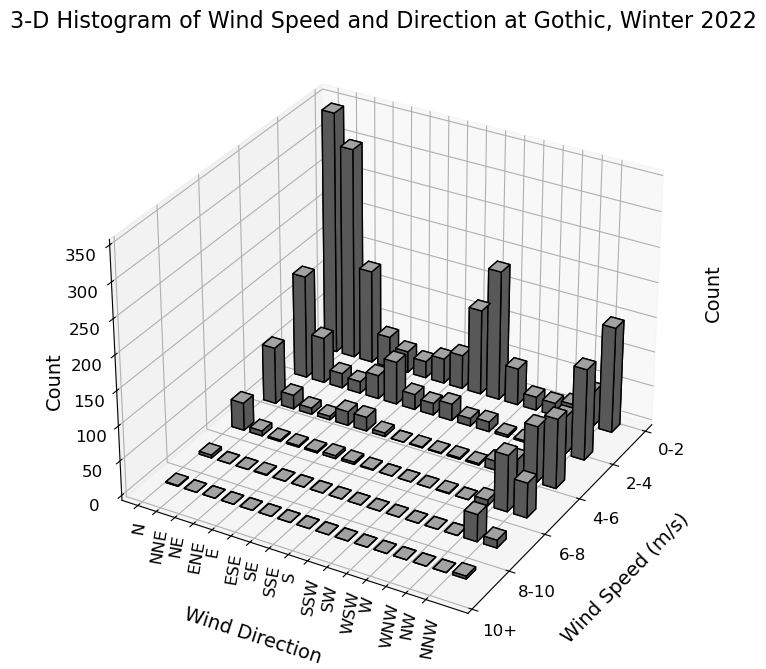

In [75]:
location = 'gothic'
if location=='kp':
    ds = w22_sail_met_kp_qc_ds_1H
    wspd_var = 'wind_spd'
    wdir_var = 'wind_dir'
    temp_var = 'mean_t'
    title = 'Kettle Ponds'
elif location=='gothic':
    ds = w22_sail_met_qc_ds_1H
    wspd_var = 'wspd_arith_mean'
    wdir_var = 'wdir_vec_mean'
    temp_var = 'temp_mean'
    title = 'Gothic'
df_to_use = ds.to_dataframe()
timestep=1

df_test = df_to_use[[wspd_var, wdir_var, temp_var]]
# create a 3d histogram in matplotlib to show the relationship between wind speed, wind direction, and total sublimation
# To generate some test data
xAmplitudes = df_test[wspd_var]#your data here
yAmplitudes = df_test[wdir_var]#your other data here


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
hist, xedges, yedges = np.histogram2d(xAmplitudes, yAmplitudes, bins=[6,16], range=[[0, 10], [0, 360]])

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1]+6.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = 0.5*np.ones_like(zpos)
dy = 15 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='max', color='lightgrey', ec='black')
# rotate the plot
ax.view_init(30, 30,0)
# replace y-axis labels with cardinal wind direction lables
ax.set_yticks([0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 180, 202.5, 225, 247.5, 270, 292.5, 315, 337.5])
ax.set_yticklabels(['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW'], rotation=80, fontsize=12, ha='left')

ax.set_xticks([0,2,4,6,8,10,])
ax.set_xticklabels(['0-2','2-4','4-6','6-8','8-10','10+'], rotation=0, fontsize=12, ha='center', va='bottom')
ax.tick_params(axis='x', pad=10)
ax.tick_params(axis='y', pad=0)
# increase tick label size on zaxis
ax.tick_params(axis='z', labelsize=12)
# ax.set_zlim(0,40)
# show z-axis on the right
ax.zaxis.set_rotate_label(False)
ax.zaxis.set_label_position('both')

ax.set_zlabel('Count', rotation=90, fontsize=14)
ax.set_xlabel('Wind Speed (m/s)', fontsize=14)
ax.set_ylabel('Wind Direction', fontsize=14)
ax.set_title(f'3-D Histogram of Wind Speed and Direction at {title}, Winter 2022', fontsize=16)
# pad the x-axis label
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20

plt.show()

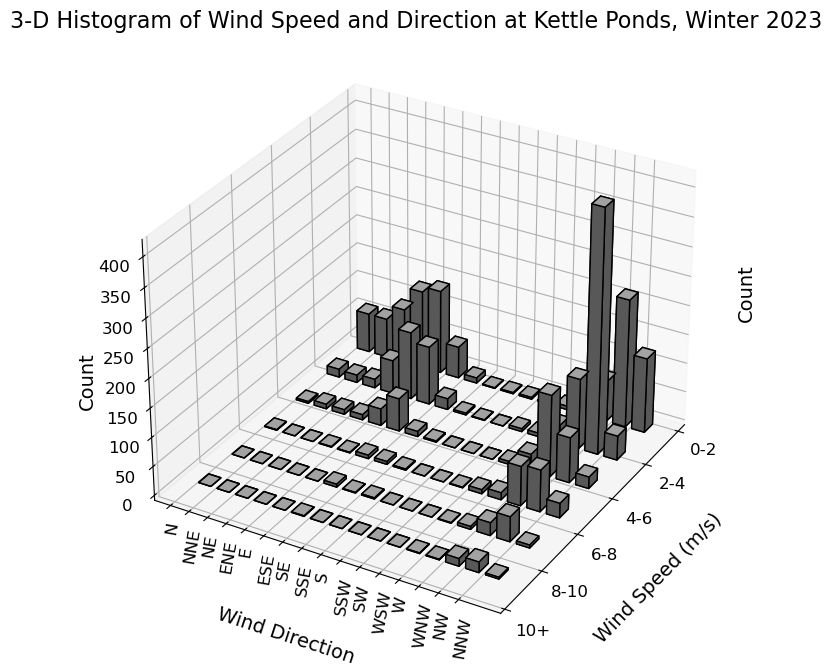

In [76]:
location = 'kp'
if location=='kp':
    ds = w23_sail_met_kp_qc_ds_1H
    wspd_var = 'wind_spd'
    wdir_var = 'wind_dir'
    temp_var = 'mean_t'
    title = 'Kettle Ponds'
elif location=='gothic':
    ds = w23_sail_met_qc_ds_1H
    wspd_var = 'wspd_arith_mean'
    wdir_var = 'wdir_vec_mean'
    temp_var = 'temp_mean'
    title = 'Gothic'
df_to_use = ds.to_dataframe()
timestep=1

df_test = df_to_use[[wspd_var, wdir_var, temp_var]]
# create a 3d histogram in matplotlib to show the relationship between wind speed, wind direction, and total sublimation
# To generate some test data
xAmplitudes = df_test[wspd_var]#your data here
yAmplitudes = df_test[wdir_var]#your other data here


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
hist, xedges, yedges = np.histogram2d(xAmplitudes, yAmplitudes, bins=[6,16], range=[[0, 10], [0, 360]])

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1]+6.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = 0.5*np.ones_like(zpos)
dy = 15 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='max', color='lightgrey', ec='black')
# rotate the plot
ax.view_init(30, 30,0)
# replace y-axis labels with cardinal wind direction lables
ax.set_yticks([0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 180, 202.5, 225, 247.5, 270, 292.5, 315, 337.5])
ax.set_yticklabels(['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW'], rotation=80, fontsize=12, ha='left')

ax.set_xticks([0,2,4,6,8,10,])
ax.set_xticklabels(['0-2','2-4','4-6','6-8','8-10','10+'], rotation=0, fontsize=12, ha='center', va='bottom')
ax.tick_params(axis='x', pad=10)
ax.tick_params(axis='y', pad=0)
# increase tick label size on zaxis
ax.tick_params(axis='z', labelsize=12)
# ax.set_zlim(0,40)
# show z-axis on the right
ax.zaxis.set_rotate_label(False)
ax.zaxis.set_label_position('both')

ax.set_zlabel('Count', rotation=90, fontsize=14)
ax.set_xlabel('Wind Speed (m/s)', fontsize=14)
ax.set_ylabel('Wind Direction', fontsize=14)
ax.set_title(f'3-D Histogram of Wind Speed and Direction at {title}, Winter 2023', fontsize=16)
# pad the x-axis label
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20

plt.show()

## 3. How much sublimation over the season came from these events?
We will address this question by calculating hourly sublimation totals from SOS and SAIL over the winter period (dates may need to be adjusted to what Eli calculated with). Then for each of the days we calculated from above, we'll get the total sublimation from those specific days. 
1) First, make a timeseries plot of cumulative sublimation over the year. Add horizontal boxes that mark the days of each wind event
2) Filter the hourly sublimation totals to just the days we want to include and sum the total. 
3) How well the days with the most sublimation correspond with these windy days.

In [77]:
ecor_ds = xr.open_dataset(w23_data_loc_dict['eddy_covariance_kettle_ponds'])
met_ds = xr.open_dataset(w23_data_loc_dict['eddy_covariance_kettle_ponds_noqc'])
# # resample to 30 minute mean
met_ds_1H = met_ds.drop_dims('bound').to_dataframe().resample('1H').mean().to_xarray()

# add mean_t to the ecor dataset
ecor_ds['mean_t'] = met_ds_1H['mean_t']
# add the mean_t attributes to ecor_ds
ecor_ds['mean_t'].attrs = met_ds['mean_t'].attrs
# latent heat of sublimation
Ls = 2834.1e3 # J/g
# latent heat of vaporization
Lv = 2500.1e3 # J/g
# density of water
rho_w = 1 # g/cm^3

# resample to hourly mean from 30 minute data, without the raw data, we are a little in the dark on these impacts
ecor_ds_attrs = ecor_ds.attrs
ecor_ds = ecor_ds.to_dataframe().resample('1H').mean().to_xarray()
ecor_ds.attrs = ecor_ds_attrs
# calculate the sublimation rate when the temperature is below 0C and evaporation rate when the temperature is above 0C
ecor_ds['e_rate'] = ecor_ds['latent_heat_flux'].where(ecor_ds['qc_latent_heat_flux']==0) *3600 * 1000/ 1000 / Ls
# ecor_ds['e_rate'] = ecor_ds['e_rate'].where(ecor_ds['mean_t'] < 0, ecor_ds['latent_heat_flux'].where(ecor_ds['qc_latent_heat_flux']==0) *3600 * 1000/ 1000 / Lv) 

In [78]:
# caclulate and plot the cumulative sum of e_rate
ds = xr.open_dataset('../../01_data/processed_data/sos_daily_h2o_flux_cleaned.nc')
# ecor_ds.e_rate.cumsum().plot()
cumulative_sos_sublimation = ds.cumsum(dim='time')

In [79]:
# scatter plot of e_rate vs ds['w_h2o__3m_uw']
df1 = ecor_ds['e_rate'].sel(time=slice('2022-12-01','2023-03-31')).to_dataframe().dropna().resample('1D').sum()
df2 = ds['w_h2o__3m_uw'].sel(time=slice('2022-12-01','2023-03-31')).to_dataframe()
df = pd.concat([df1, df2], axis=1)

fig = px.scatter(df, 
                 x='w_h2o__3m_uw', 
                 y='e_rate', 
                 title='SAIL vs SOS Daily Sublimation on UW Tower')
# add black edges to markers
fig.update_traces(marker=dict(line=dict(width=1, color='black'), size=10))
# add 1:1 line
fig.add_trace(go.Scatter(x=[-0.1, 2], y=[-0.1, 2], mode='lines', name='1:1 Line', line=dict(color='black', dash='dash')))
fig.update_layout(
    xaxis_title='SOS 10m Water Vapor Flux (mm/day)',
    yaxis_title='SAIL Sublimation Rate (mm/day)',
    width=800,
    height=600,
)

In [80]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=ecor_ds['e_rate'].sel(time=slice('2022-11-30','2023-05-09')).resample(time='1D').sum().cumsum().time, 
                         y=ecor_ds['e_rate'].sel(time=slice('2022-11-30','2023-05-09')).resample(time='1D').sum().cumsum().values, 
                         name='SAIL ECOR Sublimation (Gothic)', 
                         line=dict(color='blue')))

# make a 4 color red colorramp from pink to red
color_ramp_1 = px.colors.sequential.Reds[2:6]                      
color_ramp_2 = px.colors.sequential.Greens[2:6]
for i, loc in enumerate(['uw','ue','d','c']):
    fig.add_trace(go.Scatter(x=ds.time,
                                y=cumulative_sos_sublimation[f'w_h2o__10m_{loc}'].values,
                                name=f'SOS Sublimation (10m {loc})',
                                line=dict(color=color_ramp_1[i])))
    fig.add_trace(go.Scatter(x=ds.time,
                                y=cumulative_sos_sublimation[f'w_h2o__3m_{loc}'].values,
                                name=f'SOS Sublimation (3m {loc})',
                                line=dict(color=color_ramp_2[i])))
fig.update_layout(title='Cumulative Sublimation at SAIL ECOR and SOS Sites',
                    xaxis_title='Date',
                    yaxis_title='Cumulative Sublimation (mm)',
                    width=1000,
                    height=600,
                    legend_title='Site')

### Make Heatmaps Sublimation with Wind Speed and Direction

### 2022

In [39]:
ecor_22_ds = xr.open_dataset(w22_data_loc_dict['eddy_covariance_kettle_ponds'])
met_22_ds = xr.open_dataset(w22_data_loc_dict['eddy_covariance_kettle_ponds_noqc'])
# # resample to 30 minute mean
met_22_ds_1H = met_22_ds.drop_dims('bound').to_dataframe().resample('1H').mean().to_xarray()

# add mean_t to the ecor dataset
ecor_22_ds['mean_t'] = met_22_ds_1H['mean_t']
# add the mean_t attributes to ecor_22_ds
ecor_22_ds['mean_t'].attrs = met_22_ds['mean_t'].attrs
# latent heat of sublimation
Ls = 2834.1e3 # J/g
# latent heat of vaporization
Lv = 2500.1e3 # J/g
# density of water
rho_w = 1 # g/cm^3

# resample to hourly mean from 30 minute data, without the raw data, we are a little in the dark on these impacts
ecor_22_ds_attrs = ecor_22_ds.attrs
ecor_22_ds = ecor_22_ds.to_dataframe().resample('1H').mean().to_xarray()
ecor_22_ds.attrs = ecor_22_ds_attrs
# calculate the sublimation rate when the temperature is below 0C and evaporation rate when the temperature is above 0C
ecor_22_ds['e_rate'] = ecor_22_ds['latent_heat_flux'].where(ecor_22_ds['qc_latent_heat_flux']==0) *3600 * 1000/ 1000 / Ls
# ecor_22_ds['e_rate'] = ecor_22_ds['e_rate'].where(ecor_22_ds['mean_t'] < 0, ecor_22_ds['latent_heat_flux'].where(ecor_22_ds['qc_latent_heat_flux']==0) *3600 * 1000/ 1000 / Lv) 

In [40]:
location = 'kp'
if location=='kp':
    ds = w22_sail_met_kp_qc_ds_1H
    # replace mean_t with the temp_mean value from w22_saile_met_qc_ds_1H
    ds['mean_t'] = w22_sail_met_qc_ds_1H['temp_mean']
    wspd_var = 'wspd_max'
    wdir_var = 'wdir_max'
    temp_var = 'mean_t'
    title = 'Kettle Ponds'
elif location=='gothic':
    ds = w22_sail_met_qc_ds_1H
    wspd_var = 'wspd_arith_mean'
    wdir_var = 'wdir_vec_mean'
    temp_var = 'temp_mean'
    title = 'Gothic'
df_to_use = ds.to_dataframe()
timestep=1

df_test = df_to_use[[wspd_var, wdir_var, temp_var]]
# lets add sublimation to the dataframe
df_test['sublimation'] = ecor_22_ds['e_rate'].sel(time=slice('2021-12-01','2022-03-31'))

Plot to show time series

In [41]:
fig = px.line(df_test,
                 x=df_test.index,
                 y='sublimation',
                 # make plot a line plot
                 
)
fig.update_layout(height=400, 
                  width=600, 
                  title='Sublimation Rate at SAIL Met Tower During Winter 2022',)
# set y scale between -0.1 and 0.3
fig.update_yaxes(range=[-0.1, 0.3])

Sublimation against wind speed and direction

In [42]:
# wind speed bins
wspd_bins = [0, 2, 4, 6, 8, 10,]
# wind direction bins
wdir_bins = [0, 45, 90, 135, 180, 225, 270, 315, 360]

# wspd cut and sum sublimation for each bin
wsp_assignment = pd.cut(df_test[wspd_var], bins=wspd_bins, labels=wspd_bins[:-1])
wsp_assignment.name = 'wsp_assignment'
# wdir cut and sum sublimation for each bin
wdir_assignment = pd.cut(df_test[wdir_var], bins=wdir_bins, labels=wdir_bins[:-1])
wdir_assignment.name = 'wdir_assignment'

# combine the two assignments and the sublimation
df_test['wsp_assignment'] = wsp_assignment.values
df_test['wdir_assignment'] = wdir_assignment.values

# groupby the wspd and wdir assignments and get the sum of w_h2o__3m_uw
grouped = df_test.groupby(['wsp_assignment', 'wdir_assignment']).sum()[f'sublimation']
# unstack and put into a dataframe
grouped =(grouped.unstack())


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [43]:
# plot grouped as a heatmap
fig = go.Figure()
fig.add_trace(go.Heatmap(z=grouped.values, 
                         x=grouped.columns, 
                         y=grouped.index,

                        colorbar={'title':'Sublimation<br>(mm)'},
                        colorscale='RdBu_r',
                        # min and max color values
                        zmin=-2,
                        zmax=2,
                        xgap=1,
                        ygap=1,
                         ))
# add grid
fig.update_layout(height=400, 
                  width=600,
                  xaxis_title='Wind Direction',
                  yaxis_title='Wind Speed',
                  title=f'Wind Speed and Wind Direction Sublimation<br>Averaging time = {timestep} Hour(s)',
                  )
# change x-axis ticks to be cardinal wind directions
fig.update_xaxes(tickvals=[0, 45, 90, 135, 180, 225, 270, 315], ticktext=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
# update y-axes ticks to be wind speed bins
fig.update_yaxes(tickvals=[0, 2, 4, 6, 8, 10, 12, 14, 16, 18], ticktext=['0-2', '2-4', '4-6', '6-8', '8-10', '10-12', '12-14', '14-16', '16-18', '18-20'])
# update legend title to legend_title='Percent of Winter Sublimation (%)'

Temperature against windspeed and wind direction

In [44]:
# wind speed bins
wspd_bins = [0, 2, 4, 6, 8, 10,]
# wind direction bins
wdir_bins = [0, 45, 90, 135, 180, 225, 270, 315, 360]

# wspd cut and sum sublimation for each bin
wsp_assignment = pd.cut(df_test[wspd_var], bins=wspd_bins, labels=wspd_bins[:-1])
wsp_assignment.name = 'wsp_assignment'
# wdir cut and sum sublimation for each bin
wdir_assignment = pd.cut(df_test[wdir_var], bins=wdir_bins, labels=wdir_bins[:-1])
wdir_assignment.name = 'wdir_assignment'

# combine the two assignments and the sublimation
df_test['wsp_assignment'] = wsp_assignment.values
df_test['wdir_assignment'] = wdir_assignment.values

# groupby the wspd and wdir assignments and get the sum of w_h2o__3m_uw
grouped = df_test.groupby(['wsp_assignment', 'wdir_assignment']).mean()[temp_var]
# unstack and put into a dataframe
grouped =(grouped.unstack())


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [45]:
# plot grouped as a heatmap
fig = go.Figure()
fig.add_trace(go.Heatmap(z=grouped.values, 
                         x=grouped.columns, 
                         y=grouped.index,

                        colorbar={'title':'Temperature<br>(&deg;C)'},
                        colorscale='RdBu_r',
                        # min and max color values
                        zmin=-10,
                        zmax=0,
                        xgap=1,
                        ygap=1,
                         ))
# add grid
fig.update_layout(height=400, 
                  width=600,
                  xaxis_title='Wind Direction',
                  yaxis_title='Wind Speed',
                  title=f'Wind Speed and Wind Direction Temperature<br>Averaging time = {timestep} Hour(s)',
                  )
# change x-axis ticks to be cardinal wind directions
fig.update_xaxes(tickvals=[0, 45, 90, 135, 180, 225, 270, 315], ticktext=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
# update y-axes ticks to be wind speed bins
fig.update_yaxes(tickvals=[0, 2, 4, 6, 8, 10, 12, 14, 16, 18], ticktext=['0-2', '2-4', '4-6', '6-8', '8-10', '10-12', '12-14', '14-16', '16-18', '18-20'])
# update legend title to legend_title='Percent of Winter Sublimation (%)'

In [46]:
# create a scatter plot with the wind speed on the x-axis and the sublimation rate on the y-axis and the markers sized by the blowing snow flux (log scale)
fig = px.scatter(df_test.dropna(), 
                 x=wspd_var, 
                 y=f'sublimation', 
                 # color by wind direction
                 color=wdir_var,
                 color_continuous_scale='twilight',
                 # provide size scale
                 title=f'Wind Speed and Sublimation Rate <br> sized by Temperature and averaged over 1H')

fig.update_traces(marker=dict(size=10,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

# now config axes appropriately
fig.update_layout(
    xaxis_domain=[0, 0.90],
    xaxis1=dict(title='Wind Speed (m/s)'),
    yaxis1=dict(title='Sublimation Rate (mm/hr)'),
    xaxis2={"domain": [0.905, 1], "matches": None, "visible": False},
    yaxis2={"title":"Temperature (&deg;C)","anchor": "free", "overlaying": "y", "side": "right", "position": 1},
    showlegend=False,
    height=600, width=1000,
)

# size the legend in a log scale
fig.update_layout(legend=dict(itemsizing='constant',))
# move the colorbar axis to the right, flip orientation
fig.update_layout(coloraxis_colorbar=dict(yanchor="top", 
                                          y=-0.2, 
                                          x=0, 
                                          xanchor="left", 
                                          title='Wind Direction (&deg;)',
                                          orientation='h'))
# add temperature to the hover
fig.update_traces(hovertemplate='Wind Speed: %{x:.2f} m/s<br>Sublimation Rate: %{y:.2f} mm/hr<br>Wind Direction: %{marker.color:.2f} &deg;')



### 2023

In [47]:
ecor_23_ds = xr.open_dataset(w23_data_loc_dict['eddy_covariance_kettle_ponds'])
met_23_ds = xr.open_dataset(w23_data_loc_dict['eddy_covariance_kettle_ponds_noqc'])
# # resample to 30 minute mean
met_23_ds_1H = met_23_ds.drop_dims('bound').to_dataframe().resample('1H').mean().to_xarray()

# add mean_t to the ecor dataset
ecor_23_ds['mean_t'] = met_23_ds_1H['mean_t']
# add the mean_t attributes to ecor_23_ds
ecor_23_ds['mean_t'].attrs = met_23_ds['mean_t'].attrs
# latent heat of sublimation
Ls = 2834.1e3 # J/g
# latent heat of vaporization
Lv = 2500.1e3 # J/g
# density of water
rho_w = 1 # g/cm^3

# resample to hourly mean from 30 minute data, without the raw data, we are a little in the dark on these impacts
ecor_23_ds_attrs = ecor_23_ds.attrs
ecor_23_ds = ecor_23_ds.to_dataframe().resample('1H').mean().to_xarray()
ecor_23_ds.attrs = ecor_23_ds_attrs
# calculate the sublimation rate when the temperature is below 0C and evaporation rate when the temperature is above 0C
ecor_23_ds['e_rate'] = ecor_23_ds['latent_heat_flux'].where(ecor_23_ds['qc_latent_heat_flux']==0) *3600 * 1000/ 1000 / Ls
# ecor_23_ds['e_rate'] = ecor_23_ds['e_rate'].where(ecor_23_ds['mean_t'] < 0, ecor_23_ds['latent_heat_flux'].where(ecor_23_ds['qc_latent_heat_flux']==0) *3600 * 1000/ 1000 / Lv) 

In [55]:
location = 'kp'
if location=='kp':
    ds = w23_sail_met_kp_qc_ds_1H
    # replace mean_t with the temp_mean value from w23_saile_met_qc_ds_1H
    ds['mean_t'] = w23_sail_met_qc_ds_1H['temp_mean']
    wspd_var = 'wind_spd'
    wdir_var = 'wind_dir'
    temp_var = 'mean_t'
    title = 'Kettle Ponds'
elif location=='gothic':
    ds = w23_sail_met_qc_ds_1H
    wspd_var = 'wspd_arith_mean'
    wdir_var = 'wdir_vec_mean'
    temp_var = 'temp_mean'
    title = 'Gothic'
df_to_use = ds.to_dataframe()
timestep=1

df_test = df_to_use[[wspd_var, wdir_var, temp_var]]
# lets add sublimation to the dataframe
df_test['sublimation'] = ecor_23_ds['e_rate'].sel(time=slice('2022-12-01','2023-03-31'))
df_test.to_csv('../../01_data/processed_data/sail_processed/w23_sail_met_kp_qc_sublimation.csv')

Plot to show time series

In [ ]:
fig = px.line(df_test,
                 x=df_test.index,
                 y='sublimation',
                 # make plot a line plot
                 
)
fig.update_layout(height=400, 
                  width=600, 
                  title='Sublimation Rate at SAIL Met Tower During Winter 2023',)
# set y scale between -0.1 and 0.3
fig.update_yaxes(range=[-0.1, 0.3])

Sublimation against wind speed and direction

In [ ]:
# wind speed bins
wspd_bins = [0, 2, 4, 6, 8, 10,]
# wind direction bins
wdir_bins = [0, 45, 90, 135, 180, 225, 270, 315, 360]

# wspd cut and sum sublimation for each bin
wsp_assignment = pd.cut(df_test[wspd_var], bins=wspd_bins, labels=wspd_bins[:-1])
wsp_assignment.name = 'wsp_assignment'
# wdir cut and sum sublimation for each bin
wdir_assignment = pd.cut(df_test[wdir_var], bins=wdir_bins, labels=wdir_bins[:-1])
wdir_assignment.name = 'wdir_assignment'

# combine the two assignments and the sublimation
df_test['wsp_assignment'] = wsp_assignment.values
df_test['wdir_assignment'] = wdir_assignment.values

# groupby the wspd and wdir assignments and get the sum of w_h2o__3m_uw
grouped = df_test.groupby(['wsp_assignment', 'wdir_assignment']).sum()[f'sublimation']
# unstack and put into a dataframe
grouped =(grouped.unstack())


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [108]:
# plot grouped as a heatmap
fig = go.Figure()
fig.add_trace(go.Heatmap(z=grouped.values, 
                         x=grouped.columns, 
                         y=grouped.index,

                        colorbar={'title':'Sublimation<br>(mm)'},
                        colorscale='RdBu_r',
                        # min and max color values
                        zmin=-2,
                        zmax=2,
                        xgap=1,
                        ygap=1,
                         ))
# add grid
fig.update_layout(height=400, 
                  width=600,
                  xaxis_title='Wind Direction',
                  yaxis_title='Wind Speed',
                  title=f'Wind Speed and Wind Direction Sublimation<br>Averaging time = {timestep} Hour(s)',
                  )
# change x-axis ticks to be cardinal wind directions
fig.update_xaxes(tickvals=[0, 45, 90, 135, 180, 225, 270, 315], ticktext=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
# update y-axes ticks to be wind speed bins
fig.update_yaxes(tickvals=[0, 2, 4, 6, 8, 10, 12, 14, 16, 18], ticktext=['0-2', '2-4', '4-6', '6-8', '8-10', '10-12', '12-14', '14-16', '16-18', '18-20'])
# update legend title to legend_title='Percent of Winter Sublimation (%)'

Temperature against windspeed and wind direction

In [49]:
# wind speed bins
wspd_bins = [0, 2, 4, 6, 8, 10,]
# wind direction bins
wdir_bins = [0, 45, 90, 135, 180, 225, 270, 315, 360]

# wspd cut and sum sublimation for each bin
wsp_assignment = pd.cut(df_test[wspd_var], bins=wspd_bins, labels=wspd_bins[:-1])
wsp_assignment.name = 'wsp_assignment'
# wdir cut and sum sublimation for each bin
wdir_assignment = pd.cut(df_test[wdir_var], bins=wdir_bins, labels=wdir_bins[:-1])
wdir_assignment.name = 'wdir_assignment'

# combine the two assignments and the sublimation
df_test['wsp_assignment'] = wsp_assignment.values
df_test['wdir_assignment'] = wdir_assignment.values

# groupby the wspd and wdir assignments and get the sum of w_h2o__3m_uw
grouped = df_test.groupby(['wsp_assignment', 'wdir_assignment']).mean()[temp_var]
# unstack and put into a dataframe
grouped =(grouped.unstack())


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [50]:
# plot grouped as a heatmap
fig = go.Figure()
fig.add_trace(go.Heatmap(z=grouped.values, 
                         x=grouped.columns, 
                         y=grouped.index,

                        colorbar={'title':'Temperature<br>(&deg;C)'},
                        colorscale='RdBu_r',
                        # min and max color values
                        zmin=-12,
                        zmax=0,
                        xgap=1,
                        ygap=1,
                         ))
# add grid
fig.update_layout(height=400, 
                  width=600,
                  xaxis_title='Wind Direction',
                  yaxis_title='Wind Speed',
                  title=f'Wind Speed and Wind Direction Temperature<br>Averaging time = {timestep} Hour(s)',
                  )
# change x-axis ticks to be cardinal wind directions
fig.update_xaxes(tickvals=[0, 45, 90, 135, 180, 225, 270, 315], ticktext=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
# update y-axes ticks to be wind speed bins
fig.update_yaxes(tickvals=[0, 2, 4, 6, 8, 10, 12, 14, 16, 18], ticktext=['0-2', '2-4', '4-6', '6-8', '8-10', '10-12', '12-14', '14-16', '16-18', '18-20'])
# update legend title to legend_title='Percent of Winter Sublimation (%)'

In [52]:
# create a scatter plot with the wind speed on the x-axis and the sublimation rate on the y-axis and the markers sized by the blowing snow flux (log scale)
fig = px.scatter(df_test.dropna(), 
                 x=wspd_var, 
                 y=f'sublimation', 
                 # color by wind direction
                 color=wdir_var,
                 color_continuous_scale='twilight',
                 # provide size scale
                 title=f'Wind Speed and Sublimation Rate <br> sized by Temperature and averaged over 1H')

fig.update_traces(marker=dict(size=10,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

# now config axes appropriately
fig.update_layout(
    xaxis_domain=[0, 0.90],
    xaxis1=dict(title='Wind Speed (m/s)'),
    yaxis1=dict(title='Sublimation Rate (mm/hr)'),
    xaxis2={"domain": [0.905, 1], "matches": None, "visible": False},
    yaxis2={"title":"Temperature (&deg;C)","anchor": "free", "overlaying": "y", "side": "right", "position": 1},
    showlegend=False,
    height=600, width=1000,
)

# size the legend in a log scale
fig.update_layout(legend=dict(itemsizing='constant',))
# move the colorbar axis to the right, flip orientation
fig.update_layout(coloraxis_colorbar=dict(yanchor="top", 
                                          y=-0.2, 
                                          x=0, 
                                          xanchor="left", 
                                          title='Wind Direction (&deg;)',
                                          orientation='h'))
# add temperature to the hover
fig.update_traces(hovertemplate='Wind Speed: %{x:.2f} m/s<br>Sublimation Rate: %{y:.2f} mm/hr<br>Wind Direction: %{marker.color:.2f} &deg;')



### Compare 2022 and 2023

In [94]:
print(f"2022 Winter Sublimation: {ecor_22_ds['e_rate'].sel(time=slice('2021-12-01','2022-03-31')).sum().values}")
# print the number of nans
print(f"2022 Winter Sublimation NaNs %: {100*(ecor_22_ds['e_rate'].sel(time=slice('2021-12-01','2022-03-31')).isnull().sum().values/len(ecor_22_ds['e_rate'].sel(time=slice('2021-12-01','2022-03-31'))))}")
print(f"2023 Winter Sublimation: {ecor_23_ds['e_rate'].sel(time=slice('2022-12-01','2023-03-31')).sum().values}")
# print the number of nans
print(f"2023 Winter Sublimation NaNs %: {100*(ecor_23_ds['e_rate'].sel(time=slice('2022-12-01','2023-03-31')).isnull().sum().values/len(ecor_23_ds['e_rate'].sel(time=slice('2022-12-01','2023-03-31'))))}")
print(f"2022 Spring Sublimation: {ecor_22_ds['e_rate'].sel(time=slice('2022-04-01','2022-05-15')).sum().values}")
# print the number of nans
print(f"2022 Spring Sublimation NaNs %: {100*(ecor_22_ds['e_rate'].sel(time=slice('2022-04-01','2022-05-15')).isnull().sum().values/len(ecor_22_ds['e_rate'].sel(time=slice('2022-04-01','2022-05-31'))))}")
print(f"2023 Spring Sublimation: {ecor_23_ds['e_rate'].sel(time=slice('2023-04-01','2023-05-15')).sum().values}")
# print the number of nans
print(f"2023 Spring Sublimation NaNs %: {100*(ecor_23_ds['e_rate'].sel(time=slice('2023-04-01','2023-05-15')).isnull().sum().values/len(ecor_23_ds['e_rate'].sel(time=slice('2023-04-01','2023-05-31'))))}")

2022 Winter Sublimation: 9.421061515808105
2022 Winter Sublimation NaNs %: 48.62258953168045
2023 Winter Sublimation: 23.218093872070312
2023 Winter Sublimation NaNs %: 37.086776859504134
2022 Spring Sublimation: 24.70949935913086
2022 Spring Sublimation NaNs %: 42.82786885245902
2023 Spring Sublimation: 22.203310012817383
2023 Spring Sublimation NaNs %: 24.316939890710383


Curious to see connection to synoptics. Also consider conditions to strong radiation driven events. 